## Logistic Regression Evaluation

In [2]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_curve

In [4]:
filename = os.path.join(os.getcwd(), "data/airbnbData_train.csv")
df = pd.read_csv(filename, header=0)

In [5]:
# Label
y = df["host_is_superhost"]

# Features
X = df.drop(columns=["host_is_superhost"])

In [6]:
# Training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)

In [7]:
model_default = LogisticRegression(max_iter=1000)
model_default.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [8]:
# Make predictions on the test data using the predict_proba() method
proba_predictions_default = model_default.predict_proba(X_test)[:, 1].tolist()


# Make predictions on the test data using the predict() method
class_label_predictions_default = model_default.predict(X_test)

In [9]:
# Evaluation accuracy using a confusion matrix
conf_matrix = confusion_matrix(y_test, class_label_predictions_default)
conf_matrix

array([[2014,  123],
       [ 429,  237]])

In [10]:
# Possible values of hyperparameter C
param_grid = {
"C": [10**i for i in range(-5,5)]
}

param_grid

{'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}

### Perform Grid Search Cross-Validation

In [11]:
print('Running Grid Search...')

model = LogisticRegression(max_iter=1000)

# Run a grid search with 5-fold cross-validation
grid = GridSearchCV(model, param_grid, cv=5)

# Fit the model on the training data
grid_search = grid.fit(X_train, y_train)
print('Done')

Running Grid Search...
Done


In [12]:
# Retrive value of hyperparameter C for the best score
best_C = grid_search.best_estimator_.C

best_C

10000

### Train, Test and Evaluate the Optimal Logistic Regression Model 

In [13]:
# Initialize LogisticRegression model with best value of C
model_best = LogisticRegression(C=10000, max_iter=1000)
model_best.fit(X_train, y_train)

LogisticRegression(C=10000, max_iter=1000)

In [14]:
# Make predictions on the test data using the predict_proba() method
proba_predictions_best = model_best.predict_proba(X_test)[:, 1].tolist()

# Make predictions on the test data using the predict() method
class_label_predictions_best = model_best.predict(X_test)


In [15]:
# Evaluate accuracy using a confusion matrix
conf_matrix = confusion_matrix(y_test, class_label_predictions_best)
conf_matrix

array([[2018,  119],
       [ 426,  240]])

### Plot Precision-Recall Curves for Both Models

In [16]:
precision_default, recall_default, thresholds_default = precision_recall_curve(y_test, proba_predictions_default)
precision_best, recall_best, thresholds_best = precision_recall_curve(y_test, proba_predictions_best)

<Axes: >

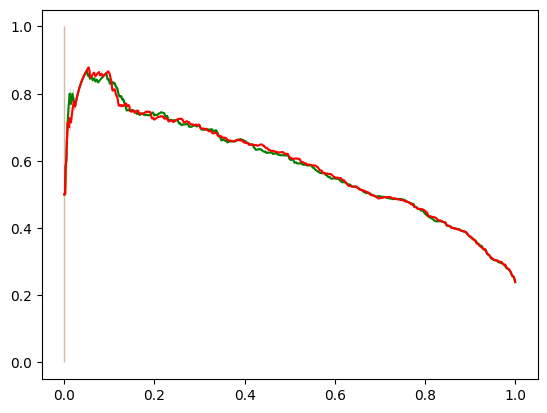

In [17]:
sns.lineplot(x=recall_default, y=precision_default, color='green')

sns.lineplot(x=recall_best, y=precision_best, color='red')

### Plot ROC Curves and Compute the AUC for Both Models

* An ROC curve plots the performance of a binary classifier for varying classification thresholds. It plots the fraction of true positives out of the positives vs. the fraction of false positives out of the negatives. 

* The AUC measures the trade-off between the true positive rate and false positive rate. It provides a broad view of the performance of a classifier since it evaluates the performance for all the possible threshold values; it essentially provides a value that summarizes the the ROC curve.

In [18]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [19]:
fpr_default, tpr_default, thresholds_default = roc_curve(y_test, proba_predictions_default)
fpr_best, tpr_best, thresholds_best = roc_curve(y_test, proba_predictions_best)

#### Plot ROC Curve for Default Hyperparameter:

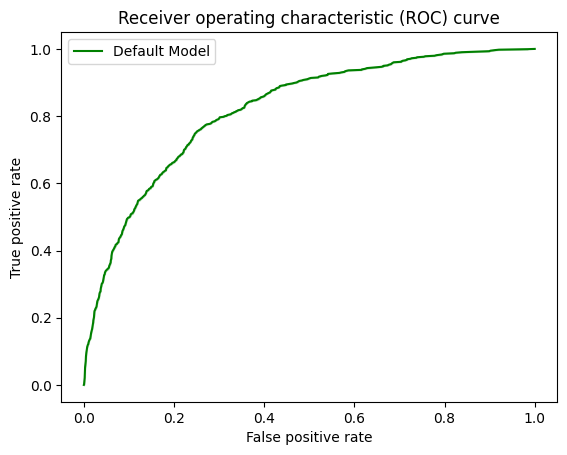

In [20]:
sns.lineplot(x=fpr_default, y=tpr_default, label='Default Model', color='green')

plt.title('Receiver operating characteristic (ROC) curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

plt.show()

#### Plot ROC Curve for Best Hyperparameter:

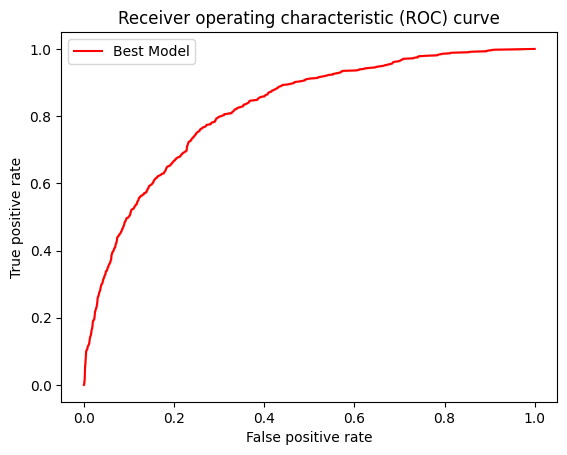

In [21]:
sns.lineplot(x=fpr_best, y=tpr_best, label='Best Model', color='red')

plt.title('Receiver operating characteristic (ROC) curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

plt.show()

In [22]:
auc_default = auc(fpr_default, tpr_default)
auc_best = auc(fpr_best, tpr_best)

print(auc_default)
print(auc_best)

0.8197699337147162
0.8210023312971371


### Feature Selection Using SelectKBest

In [23]:
# Extract the best 5 features from the Airbnb "listings" data set to create new training data, 
# then fit the model with the optimal hyperparameter C to the data and compute the AUC.

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# k=5 is specifying the top 5 features
selector = SelectKBest(f_classif, k=5)
selector.fit(X, y)
filter = selector.get_support()
top_5_features = X.columns[filter]

print("Best 5 features:")
print(top_5_features)

# Create new training and test data for features
new_X_train = X_train[top_5_features]
new_X_test = X_test[top_5_features]


# Initialize a LogisticRegression model object with the best value of hyperparameter C 
model = LogisticRegression(max_iter=1000)

# Fit the model to the new training data
model.fit(new_X_train, y_train)

proba_predictions = model.predict_proba(new_X_test)[:, 1].tolist()

# Compute the auc-roc
fpr, tpr, thresholds = roc_curve(y_test, proba_predictions)
auc_result = auc(fpr, tpr)
print(auc_result)


Best 5 features:
Index(['host_response_rate', 'number_of_reviews', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'review_scores_cleanliness'],
      dtype='object')
0.7913014792986717


### Make Model Persistent

In [22]:
import pickle

In [30]:
pkl_model_lab5 = "model.pkl"
file = pickle.dump(model_best, open(pkl_model_lab5, 'wb'))

In [31]:
persistent_model = pickle.load(open(pkl_model_lab5, 'rb'))
prediction = persistent_model.predict(X_test)
prediction

array([False, False, False, ...,  True, False, False])